# Motor sequence learning with SOMs and AIF

In this notebook, we train a sensorimotor architecture to learn in an unsupervised way a repertoire of simple motor trajectories. The implementation is based on a Kohonen network / self organizing map, and on active inference.

In [1]:
import numpy as np
import pickle as pk
import torch
from torch import nn

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

## Environment

The environment simulates a simple canvas for drawing. The agent perceives images of the canvas, and can affect the environment through 2D actions corresponding to the angle velocity of a 2 dof simulated arm.

In [2]:
class DrawingEnv(object):
    
    def __init__(self, width=60, height=60):
        
        # Initialize figure
        self.fig = plt.figure(figsize=(1, 1), dpi=64, frameon=False)
        self.width = width
        self.height = height
        
        # Initialize trajectory
        self.traj = np.zeros((2, 1))
        
    def step(self, action):
        assert(action.shape[0] == 2)
        assert(action.shape[1] == 1)
        self.traj = np.concatenate((self.traj, action), axis=1)
        
    def sensory_state(self):
        
        # Method that returns the image state of the environment as a screenshot from the pyplot figure
        ax = plt.Axes(self.fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        ax.set_xlim(-self.width, self.width)
        ax.set_ylim(-self.height, self.height)
        self.fig.add_axes(ax)
        ax.plot(self.traj[0, :], self.traj[1, :], color='black')
        
        self.fig.canvas.draw()
        w,h = self.fig.canvas.get_width_height()
        array = np.frombuffer(self.fig.canvas.tostring_argb(), dtype=np.uint8)
        array.shape = (w, h, 4)

        self.fig.clf()
        
        return 1 - array[:, :, 0]/255
    
    def reset(self):
        self.traj = np.zeros((2, 1))
        self.fig.clf()

## Model

The architecture is composed of two substructures: a kohonen map for perception, and a randomly connected RNN for motor trajectories generation. Motor trajectories learning with Active Inference is performed using a random search algorithm.

First, the RNN generating motor trajectories:

In [3]:
class ESN(nn.Module):
    
    def __init__(self, states_dim, output_dim, proba, sigma, tau):
        super(ESN, self).__init__()
        
        self.states_dim = states_dim
        self.output_dim = output_dim
        self.proba = proba  # Recurrent weights probability of connection
        self.sigma = sigma  # Recurrent weights aplitude
        self.tau = tau  # Time constant
        
        # Output weights initialization
        self.w_o = torch.randn(self.output_dim, self.states_dim) / self.states_dim
        self.b_o = torch.randn(self.output_dim)/10
        
        # Recurrent weights initialization
        self.w_r = torch.randn(self.states_dim, self.states_dim) * sigma
        self.connect = torch.rand(self.states_dim, self.states_dim) < proba
        self.w_r *= self.connect
        self.b_r = torch.randn(self.states_dim)/10
        
    def forward(self, seq_len, h_init, store=True):
        """
        Forward pass through the network.
        Parameters:
        - seq_len : number of time steps, int
        - h_init : initial hidden state, Tensor of shape (batch_size, states_dim)
        """

        batch_size, _ = h_init.shape
        
        # Initial hidden state and hidden causes
        h = h_init
        
        # Prediction
        xs = torch.zeros(seq_len, batch_size, self.output_dim)
        
        for t in range(seq_len):
            
            # Compute h
            h = (1-1/self.tau) * h + (1/self.tau) * (
                torch.mm(
                    torch.tanh(h),
                    self.w_r.T
                ) + self.b_r.unsqueeze(0).repeat(batch_size, 1)
            )

            # Compute x_pred according to h
            x =  torch.mm(torch.tanh(h), self.w_o.T) + self.b_o.unsqueeze(0).repeat(batch_size, 1)
            xs[t] = x
                       
        return xs

Note that no learning is performed in this model, the recurrent and output weights are initialized randomly and remained unchanged.

Second, the perceptual model corresponds to a Kohonen map. We chose a ring topology (one cyclic dimension) for the neighborhood function. The network receives as input an image of the environment and classifies it according to the closest prototype. Learning is performed in parallel of the forward pass, the prototypes are updated according to the received image input and a neighborhood function.

In [4]:
class RingKohonenLayer(nn.Module):
    
    def __init__(self, input_dim, grid_dim_cyclic=10, grid_dim_linear=10, grid_spread=2, lr=.1):
        super(RingKohonenLayer, self).__init__()
        self.input_dim = input_dim
        self.grid_dim_cyclic = grid_dim_cyclic
        self.grid_dim_linear = grid_dim_linear
        self.grid_spread = grid_spread
        self.lr = lr
        
        self.a = None
        self.w = None
        self.nf = None
        self.reset()
        
    def reset(self):
        self.w = 1 - torch.rand((self.grid_dim_cyclic * self.grid_dim_linear, self.input_dim))* .1
        self.build_nf()      
    
    def build_nf(self, repel_coef=.0):
        # Method that creates a neighborhood function in the shape of a matrix
        # The repel coef determines the depth of the hat shape of the function
    
        # Neighbourhood function
        self.nf = torch.zeros(self.grid_dim_cyclic*2-1, self.grid_dim_linear*2-1)
        for i in range(self.grid_dim_cyclic*2-1):
            for j in range(self.grid_dim_linear*2-1):
                self.nf[i, j] = \
                    (1. + repel_coef) * np.exp((-(((i+1+self.grid_dim_cyclic/2)%self.grid_dim_cyclic)-(self.grid_dim_cyclic/2))**2 - (j-self.grid_dim_linear+1)**2)/((self.grid_spread*1)**2)) -\
                    repel_coef * np.exp((-(((i+1+self.grid_dim_cyclic/2)%self.grid_dim_cyclic)-(self.grid_dim_cyclic/2))**2 - (j-self.grid_dim_linear+1)**2)/((self.grid_spread*2)**2)) 
                
    def forward(self, i):
        
        i = i.ravel()
        
        # Compute all the distances
        distances = ((self.w - i) ** 2).sum(axis=-1)
        
        # Activated neuron is the argmin of the distances
        win = int(torch.argmin(distances))
        
        # We update the kohonen filters of the neurons in the neighbourhood of the winner neuron
        x, y = np.unravel_index(win, (self.grid_dim_cyclic, self.grid_dim_linear))
        
        self.w += (
            (
                self.nf[self.grid_dim_cyclic-x-1:2*self.grid_dim_cyclic-x-1, self.grid_dim_linear-y-1:2*self.grid_dim_linear-y-1]
            ).reshape(self.grid_dim_cyclic * self.grid_dim_linear, 1).repeat(1, self.w.shape[1])
        ) * (i - self.w) * self.lr
        
        return win, distances[win]


Finally, a random search algorithm is used to learn the optimal RNN initial activations. The initial activations are optimized in order to maximize a reward signal (here a goal-based negative variational free-energy (or ELBO)). This optimization is done through iterative random updates that are either kept or disregarded depending on whether they improve or worsen the reward.

In [5]:
class RSNetwork(nn.Module):
    # This class called RSNetwork stands for Random Search. 
    # It performs random search on a set of vectors of dim output_dim.
    
    def __init__(self, input_dim, output_dim, alpha=100, search_std=1e-2, search_directions=3):
        super(RSNetwork, self).__init__()
        self.input_dim = input_dim  # The number of trajectories that we learn
        self.output_dim = output_dim  # The dimension of the control signal
        self.alpha = alpha  # Learning rate
        self.search_std = search_std  # Std of the search vectors sampled from a normal distribution
        self.search_directions = search_directions  # Number of search directions to pursue in parallel
        self.weights = torch.zeros(self.output_dim, self.input_dim)  # The control signals for each trajectory
        self.deltas = None  # The search vectors
        self.resample_deltas() 
    
    def resample_deltas(self):
        self.deltas = [
            torch.randn(self.output_dim, self.input_dim) * self.search_std for _ in range(self.search_directions)
        ]
    
    def forward(self, i):
        return [
            torch.matmul(self.weights + a * self.deltas[k], i) for k in range(self.search_directions) for a in (-1, 1)
        ]
    
    def forward_no_deltas(self, i):
        return torch.matmul(self.weights, i)
    
    def backward(self, rs, index=-1):
        # If an index is provided, we learn only the search signal corresponding to this index
        
        assert(len(rs) == self.search_directions * 2)
        
        if index < 0:
            self.weights += self.alpha * sum([
                a * rs[k*2+i] * self.deltas[k]
                for k in range(self.search_directions) for i, a in enumerate([-1, 1])
            ])
        else:
            self.weights[:, index] += self.alpha  * sum([
                a * rs[k*2+i] * self.deltas[k][:, index]
                for k in range(self.search_directions) for i, a in enumerate([-1, 1])
            ])

## Training

The architecture is trained in order to generate diverse motor trajectories. The Kohonen topology organizes in parallel with the learning of the optimal motor trajectories.

Here are the parameters for this experiment:

In [6]:
# Length of trajectories
limit=100

# Dimension of RNN
recurrent_dim = 100

# Initialize environment
env = DrawingEnv()

# Perception : kohonen network
n = 50
ring_net = RingKohonenLayer(64*64, n, 1, 1)

# Motor reservoir
rnn = ESN(recurrent_dim, 2, 0.6, 1.5, 50)

# Inverse model : RS network
controller = RSNetwork(n, recurrent_dim, search_directions=5)

# Coefficient used for computation of the complexity
beta = 8

# Env dimension
l = 60

# Number of epochs
epochs = 20000

stds = [1 - (np.tanh(20*(e-3*epochs/4)/epochs)+1)/2 for e in range(epochs)]
grid_spreads = [10*np.exp(-6*e/epochs) for e in range(epochs)]

<Figure size 64x64 with 0 Axes>

The training loop is performed in the next block. At each training iteration, we randomly sample one goal to train on. One iteration of random search is performed using this goal. For a given initial RNN activation, we compute the corresponding motor trajectory. The environment provides the image corresponding to the execution of the trajectory. This image is processed by the Kohonen map, that updates its prototypes accordingly. Variational free-energy is computed based on the resuting classification, and is used as a teaching signal for the random search algorithm.

In [7]:
complexities = [[] for i in range(n)]
accuracies = [[] for i in range(n)]
distances = [[] for i in range(n)]
filters = []

indices = torch.zeros(epochs)

for e in tqdm(range(epochs)):

    # Controller parameters
    controller.search_std = stds[e]
    
    # Kohonen parameters
    if e < .7*epochs:

        if e == 0:
            # For initialization of the kohonen filters
            ring_net.grid_spread = 100
            ring_net.build_nf(0)
            ring_net.lr=1
            
        else:  
            ring_net.grid_spread = grid_spreads[e]
            ring_net.build_nf(0)
            ring_net.lr = 0.01
            
        controller.alpha = 0.00001/controller.search_std
            
    else:
        ring_net.lr = 0
        controller.alpha = 0.001/controller.search_std


    # Save rewards
    rs = []
    
    # Choose one active neuron in the controller
    index = np.random.randint(ring_net.grid_dim_cyclic)
    indices[e] = index
    
    # Goal image as kohonen filters
    goal_image = ring_net.w[index].reshape(64, 64).clone()
    
    # Compute the corresponding states of the reservoir
    one_hot = torch.zeros(controller.input_dim)
    one_hot[index] = 1
            
    # Resample controller search deltas
    controller.resample_deltas()

    # Compute state
    states = controller.forward(one_hot)

    for sd in range(controller.search_directions * 2):

        # Reset env
        env.reset()

        # Compute the motor trajectory
        ang_vel = rnn.forward(limit, states[sd].unsqueeze(0)).numpy()[:, 0]
        
        # Compute the future sensory observation based on the motor trajectory
        for t in range(limit):
            if t == 0:
                angles = np.array([-np.pi/12, 2*np.pi/3])
            angles += ang_vel[t]/10
            action = l * (-np.sqrt(2)/2 + np.array([[np.cos(angles[0]) + np.cos(angles[0] + angles[1])],[np.sin(angles[0]) + np.sin(angles[0] + angles[1])]]))
            env.step(action)

        sensory_state = torch.Tensor(env.sensory_state())
        
        # Learning of the kohonen
        w_index, distance = ring_net.forward(sensory_state)
        distances[index].append(distance)
        
        # Compute accuracy
        ftarget = goal_image * 0.999 + 0.0005
        accuracy = -torch.sum(sensory_state * torch.log(ftarget) + (torch.ones_like(sensory_state)-sensory_state) * torch.log(torch.ones_like(ftarget)-ftarget))
        accuracies[index].append(accuracy)
        
        # Compute complexity
        d_neuron = min(min(abs(w_index - index), abs(w_index + n - index)), abs(w_index - n - index))
        complexity = -np.log(
            np.exp(-beta*d_neuron) / np.sum(np.exp(-beta*np.min(np.array([np.arange(n), n-np.arange(n)]), axis=0)))
        )
        complexities[index].append(complexity)
        
        # Compute FE
        fe = accuracy + complexity
        rs.append(-fe)

    # Learning of the inverse model
    controller.backward(rs, index)                
                    
    # Save filters
    if e%int(epochs/10) == int(epochs/10)-1:
        filters.append(np.copy(ring_net.w))
    

  0%|          | 0/20000 [00:00<?, ?it/s]

## Results

In this figure, we plot the evolution of the complexity and negative accuracy during training. We observe that in the beginning the inaccuracy increases because the Kohonen map organized and builds precise prototypes. In a second phase, the motor trajectories become more accurate at reproducing the desired sensory patterns.

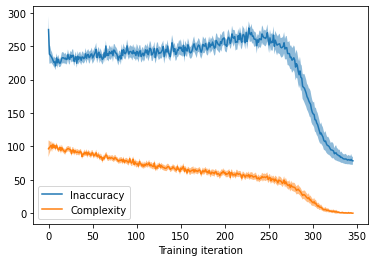

In [8]:
acc = [np.mean(np.array(accuracy).reshape(int(len(accuracy)/10), 10), axis=1) for accuracy in accuracies]

min_len = np.min([len(acc[i]) for i in range(n)])
array = np.array([np.array(acc[i][:min_len]) for i in range(n)])

plt.figure(figsize=(6,4))
plt.plot(np.mean(array, axis=0), label='Inaccuracy')
plt.fill_between(np.arange(min_len), np.mean(array, axis=0) - 1.96 * np.std(array, axis=0) / np.sqrt(n), np.mean(array, axis=0) + 1.96 * np.std(array, axis=0) / np.sqrt(n), alpha=0.5)

comp = [np.mean(np.array(complexity).reshape(int(len(complexity)/10), 10), axis=1) for complexity in complexities]

min_len = np.min([len(comp[i]) for i in range(n)])
array = np.array([np.array(comp[i][:min_len]) for i in range(n)])

plt.plot(np.mean(array, axis=0), label='Complexity')
plt.fill_between(np.arange(min_len), np.mean(array, axis=0) - 1.96 * np.std(array, axis=0) / np.sqrt(n), np.mean(array, axis=0) + 1.96 * np.std(array, axis=0) / np.sqrt(n), alpha=0.5)


plt.xlabel('Training iteration')
plt.legend()

plt.show()

In this second figure, we plot the learned Kohonen prototypes (in magenta) and the corresponding learned motor trajectories (in cyan). The order of the figures is from left to right, top to bottom. The learned visuomotor repertoire has a cyclic topology: the last prototype is close to the first one.

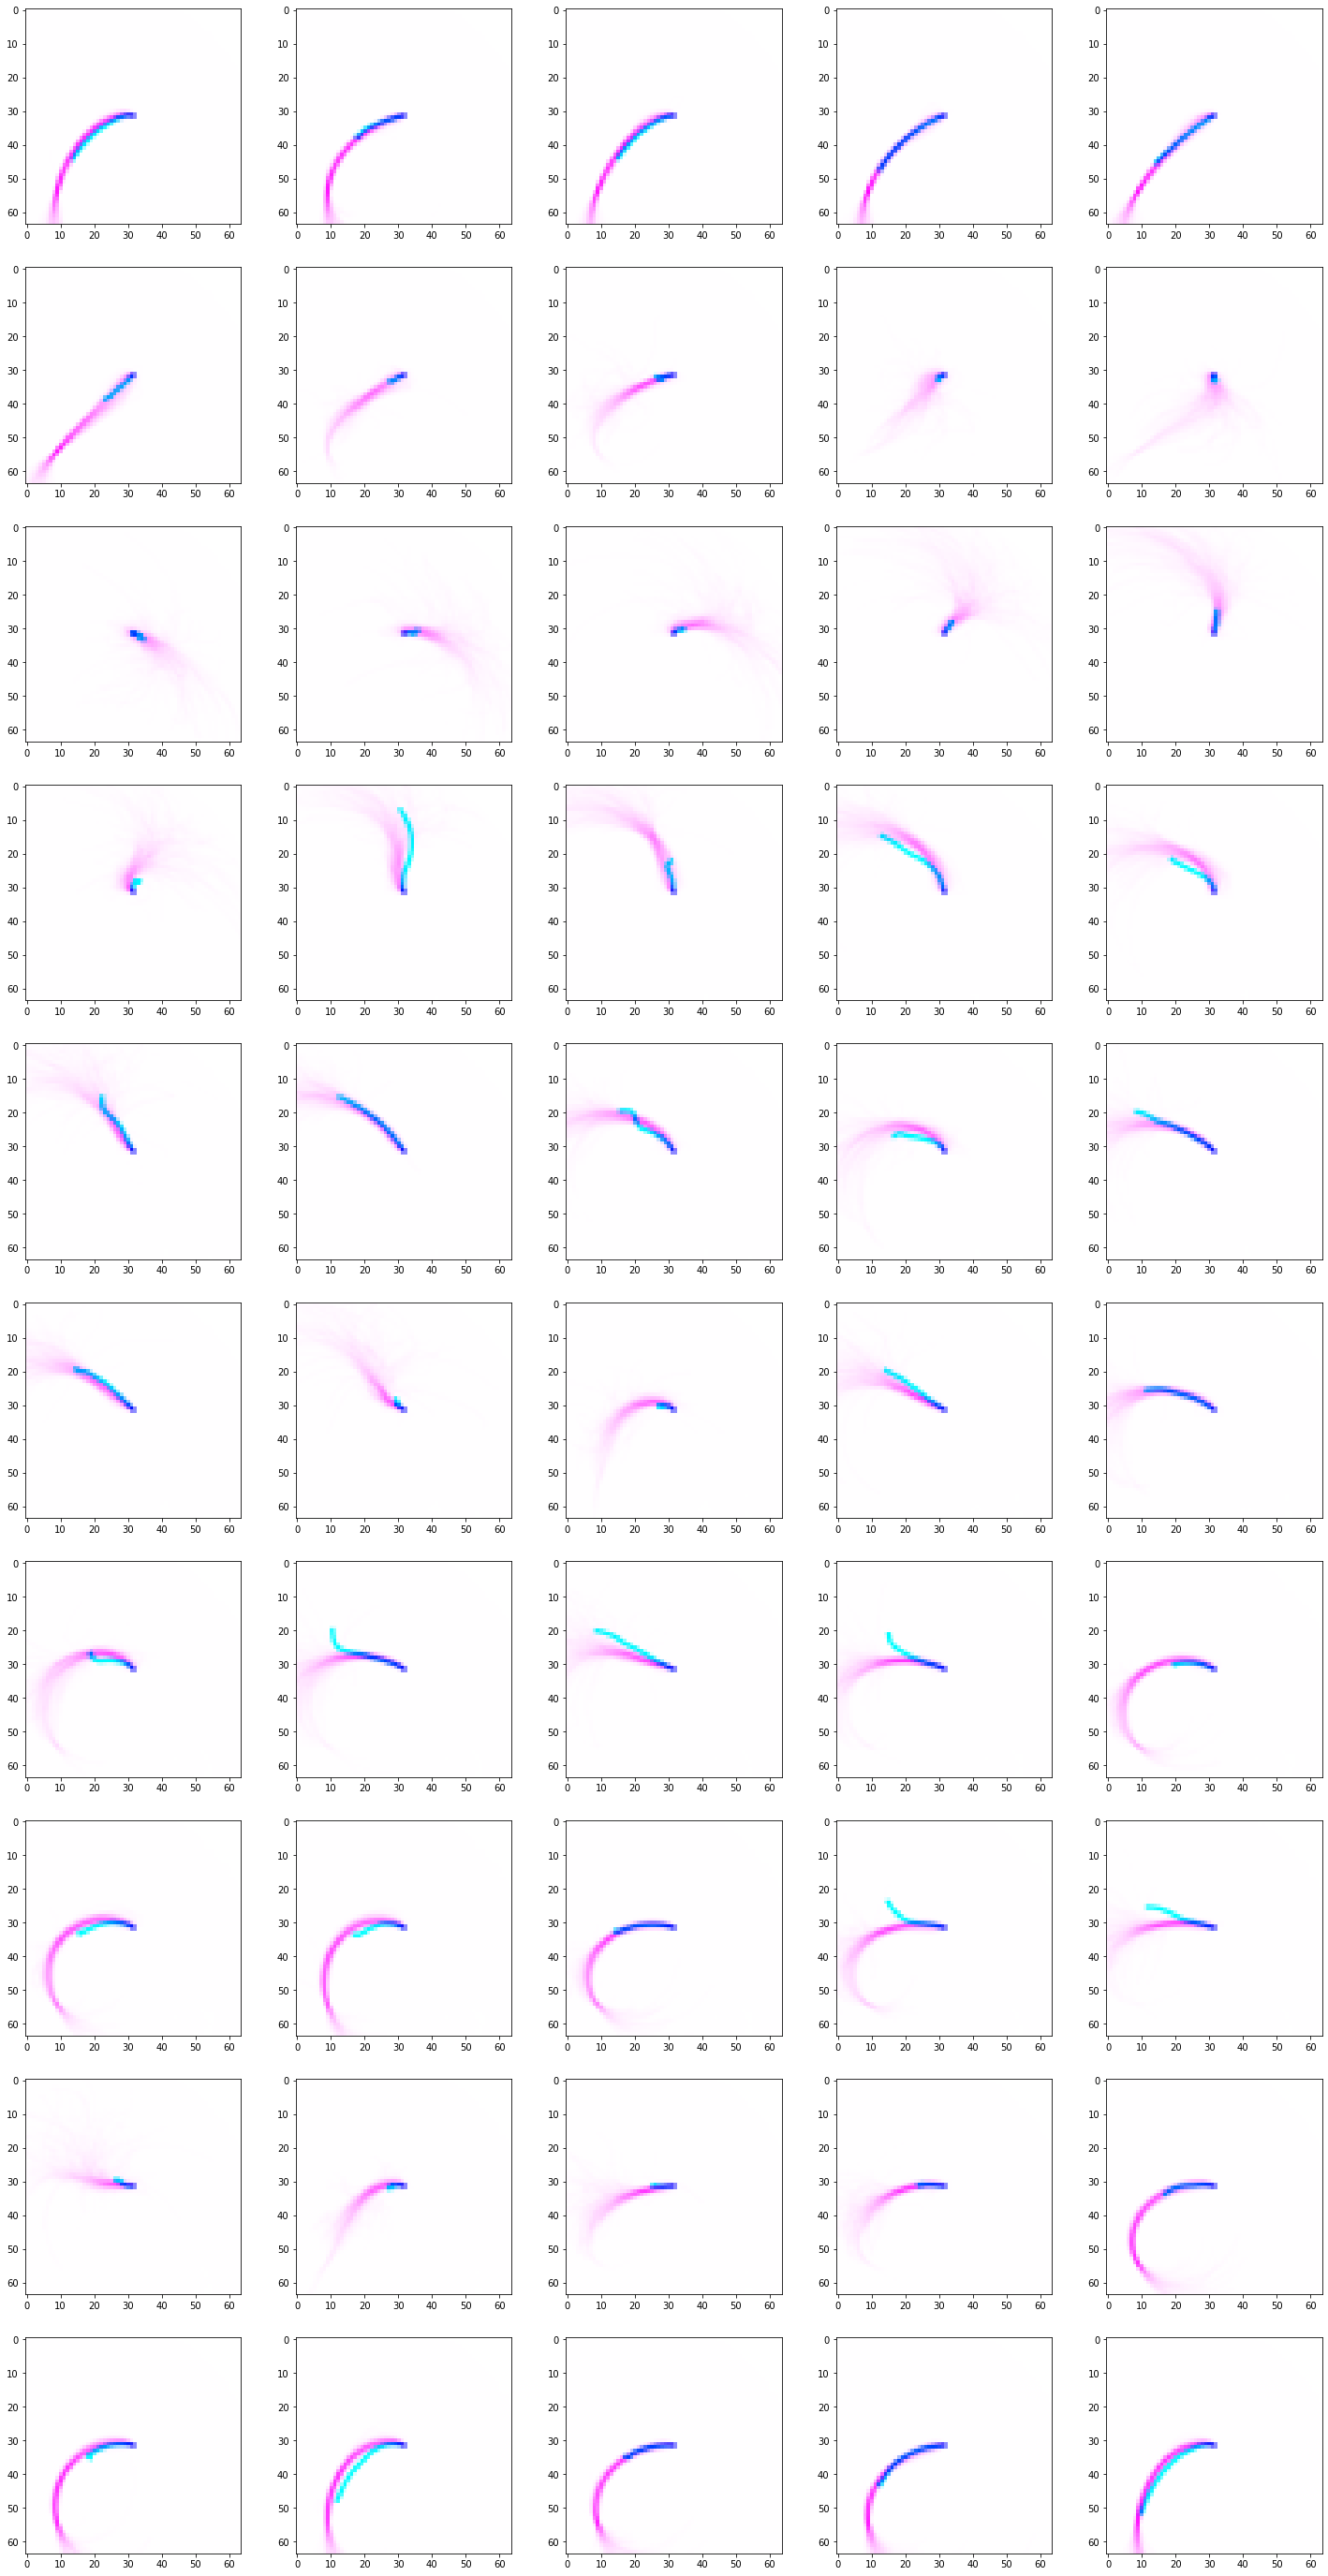

In [9]:
# This figure plots in pink the kohonen filters and in blue the obtained trajectories after training.

plt.figure(figsize=(25, 50))
for i in range(ring_net.grid_dim_cyclic):
    env.reset()
    one_hot = np.zeros(controller.input_dim)
    one_hot[i] = 1

    # Compute the initial states of the recurrent network
    state = np.dot(controller.weights, one_hot)
    ang_vel = rnn.forward(limit, torch.Tensor(state).unsqueeze(0)).numpy()[:, 0]
    
    for t in range(limit):
        if t == 0:
            angles = np.array([-np.pi/12, 2*np.pi/3])
        angles += ang_vel[t].reshape(2)/30
        action = l * (-np.sqrt(2)/2 + np.array([[np.cos(angles[0]) + np.cos(angles[0] + angles[1])],[np.sin(angles[0]) + np.sin(angles[0] + angles[1])]]))
        env.step(action)

    ax = plt.subplot(10, 5, i+1)
    image = 1 + np.zeros((64, 64, 3))
    image[:, :, 0] = env.sensory_state()
    image[:, :, 1] = ring_net.w[i].reshape(64, 64)
    ax.imshow(image)
